In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/augmented-dataset-csv/augmented_dataset.csv


In [3]:
import pandas as pd

In [4]:
# Ссылка на скачивание данных в формате CSV
csv_data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT3Wns_gLiMDfacVgF-x4suNvnAFmgibVkrsizkKqwcVFGSYAVOVnJsoV7gm3jguw/pub?gid=681978523&single=true&output=csv"

# Загрузка данных в DataFrame
data = pd.read_csv(csv_data_url)

# Просмотр первых нескольких строк данных
print(data.head())

   Unnamed: 0                                       problem_text  \
0           0  To prove that the sum of the numbers of the ex...   
1           1  ( b) Will the statement of the previous challe...   
2           2  The quadratic three-member graph with the coef...   
3           3  Can you draw on the surface of Rubik's cube a ...   
4           4  Dima, who came from Vrunlandia, said that ther...   

           topic  
0  number_theory  
1  number_theory  
2       polynoms  
3  combinatorics  
4         graphs  


In [5]:
len(data)

5273

In [6]:
# Предположим, что 'cleaned_text' это имя столбца, в котором нужно найти дубликаты
duplicates = data.duplicated(subset=['problem_text'], keep=False)

# Считаем количество дубликатов
num_duplicates = duplicates.sum()

# Выводим количество дубликатов
print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')


Количество дубликатов в столбце "problem_text": 1720


In [7]:
# Удаляем дубликаты, оставляя только первые вхождения
data_no_dupes = data.drop_duplicates(subset=['problem_text'], keep='first')

# Перезаписываем индексы после удаления дубликатов
data_no_dupes.reset_index(drop=True, inplace=True)


In [8]:
# Предположим, что 'cleaned_text' это имя столбца, в котором нужно найти дубликаты
duplicates = data_no_dupes.duplicated(subset=['problem_text'], keep=False)

# Считаем количество дубликатов
num_duplicates = duplicates.sum()

# Выводим количество дубликатов
print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')

Количество дубликатов в столбце "problem_text": 0


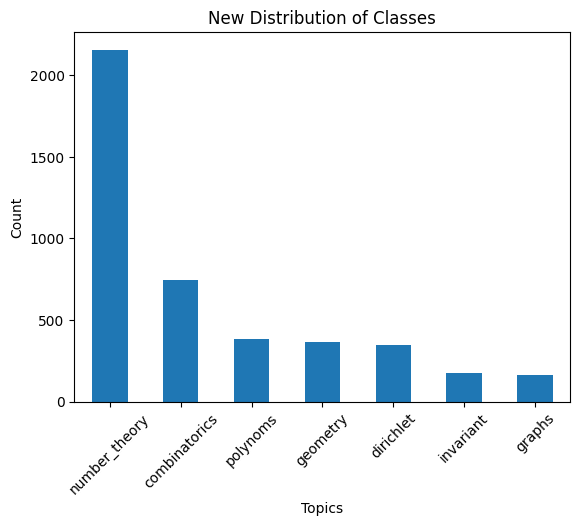

In [9]:
import matplotlib.pyplot as plt

class_counts = data_no_dupes['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [10]:
class_counts

topic
number_theory    2156
combinatorics     743
polynoms          380
geometry          364
dirichlet         344
invariant         172
graphs            160
Name: count, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

# Разделение датасета
train, test_val = train_test_split(data_no_dupes, test_size=0.4, random_state=42)
val, test = train_test_split(test_val, test_size=0.5, random_state=42)

# Теперь можешь применить аугментацию к train
# Например, используя библиотеку nlpaug как описано выше

# После аугментации, сохрани все наборы данных для дальнейшего использования
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)


In [12]:
!ls -la /kaggle/working

total 1084
drwxr-xr-x 3 root root   4096 Apr 29 19:13 .
drwxr-xr-x 5 root root   4096 Apr 29 19:01 ..
drwxr-xr-x 2 root root   4096 Apr 29 19:01 .virtual_documents
-rw-r--r-- 1 root root 221816 Apr 29 19:13 test.csv
-rw-r--r-- 1 root root 645934 Apr 29 19:13 train.csv
-rw-r--r-- 1 root root 221225 Apr 29 19:13 val.csv


In [13]:
train.head()

,Unnamed: 0,problem_text,topic
2659,3017,What numbers should be put instead of stars to...,number_theory
1613,1745,"In the town of Little 15 phones, can they be w...",combinatorics
835,868,Prove that the number is divided by 2k and not...,number_theory
1405,1497,What is the greatest amount of (a) okay; (b) i...,invariant
4026,4823,"Are there such natural numbers a, b and c that...",polynoms


In [18]:
!pip install nlpaug numpy matplotlib python-dotenv


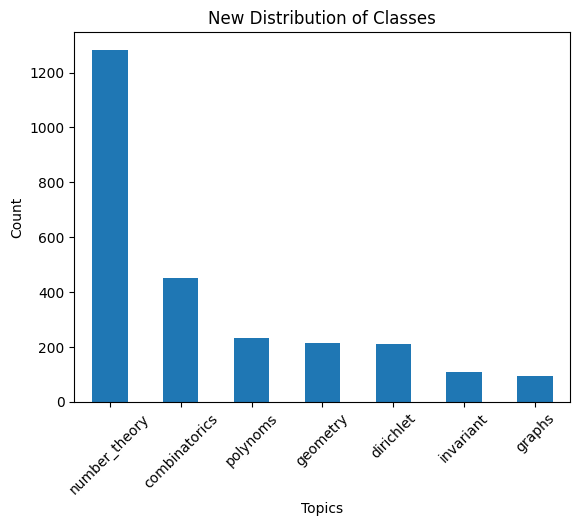

In [16]:
import matplotlib.pyplot as plt

class_counts = train['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [17]:
class_counts

topic
number_theory    1284
combinatorics     451
polynoms          231
geometry          212
dirichlet         211
invariant         109
graphs             93
Name: count, dtype: int64

In [20]:
# we augment it using nlpaug

import nlpaug.augmenter.word as naw
import pandas as pd
import torch
torch.set_printoptions(profile="full")

torch.set_num_threads(1)


# Инициализация аугментатора BERT
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", device='cuda')

# Определение максимального количества примеров в классе
max_samples = train['topic'].value_counts().max()

# Создание пустого DataFrame для аугментированных данных
augmented_data = pd.DataFrame(columns=train.columns)

# Аугментация данных
for topic in train['topic'].unique():
    # Вычисление необходимого количества аугментаций для класса
    current_count = train[train['topic'] == topic].shape[0]
    augment_count = max_samples - current_count
    
    if augment_count > 0:
        # Выборка случайных примеров для аугментации
        sample = train[train['topic'] == topic].sample(n=augment_count, replace=True)
        
        # Применение аугментации
        sample['problem_text'] = sample['problem_text'].apply(lambda x: aug.augment(x))
        
        # Добавление аугментированных примеров в датасет
        augmented_data = pd.concat([augmented_data, sample])

# Объединение аугментированных данных с исходным обучающим датасетом
train_augmented = pd.concat([train, augmented_data])

# Перемешиваем данные
train_augmented = train_augmented.sample(frac=1).reset_index(drop=True)

# Сохраняем аугментированный датасет в новый CSV-файл
train_augmented.to_csv('train_augmented.csv', index=False)


In [21]:
len(train_augmented)

8988

In [22]:
!ls -la /kaggle/working

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


total 3740
drwxr-xr-x 3 root root    4096 Apr 29 19:36 .
drwxr-xr-x 5 root root    4096 Apr 29 19:01 ..
drwxr-xr-x 2 root root    4096 Apr 29 19:01 .virtual_documents
-rw-r--r-- 1 root root  221816 Apr 29 19:13 test.csv
-rw-r--r-- 1 root root  645934 Apr 29 19:13 train.csv
-rw-r--r-- 1 root root 2717476 Apr 29 19:36 train_augmented.csv
-rw-r--r-- 1 root root  221225 Apr 29 19:13 val.csv


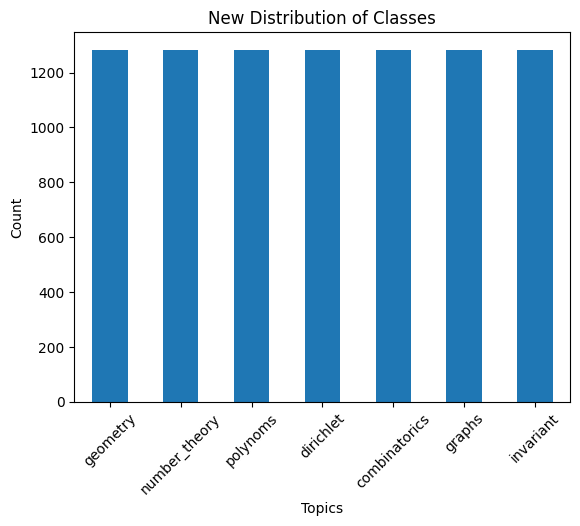

In [23]:
import matplotlib.pyplot as plt

class_counts = train_augmented['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [24]:
duplicates = train_augmented.duplicated(subset=['problem_text'], keep=False)

num_duplicates = duplicates.sum()

print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')

Количество дубликатов в столбце "problem_text": 10


Пойдем решать задачу по плану

# Подготовка данных:

# Анализ и балансировка классов:
# 

Посмотрим, сколько примеров есть в каждом классе (теме).   
Если некоторые классы недопредставлены, может потребоваться выполнить **дополнительные шаги**, 
такие как аугментация данных для меньших классов или использование взвешивания классов при обучении модели.

# Шаг 1: Сбор данных
Проверим сбалансированность классов. Ты можешь использовать следующий код для отображения количества примеров для каждого класса:

In [ ]:
print(data.columns)

In [ ]:
import matplotlib.pyplot as plt

# Предполагая, что у тебя есть колонка 'theme' для тем в твоем DataFrame 'data'
class_counts = data['topic'].value_counts()

# Выведем количество данных по каждой теме
print(class_counts)

# Построим график распределения классов
class_counts.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Темы/topic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel('Количество')
plt.show()


Если распределение классов сильно несбалансировано, рассмотри возможность использования техник,      
таких как взвешивание классов во время обучения или oversampling/undersampling для более редких/частых классов.

классы в датасете распределены неравномерно. Класс number_theory (теория чисел)     
значительно превосходит другие классы по количеству примеров.     
Такое распределение может привести к предвзятости модели: она будет лучше распознавать классы,     
для которых имеется больше обучающих данных, и хуже — для классов с меньшим количеством данных.

В случае текстовых данных, oversampling с аугментацией текста обычно     
является хорошим выбором. Нужно стремиться сохранить как можно больше информации
в обучающем наборе, одновременно стремясь к его сбалансированности.


Сначала лучше выполнить предобработку данных. Предобработка поможет очистить данные и привести их к формату, который будет более полезен для обучения модели. Это также упростит последующую аугментацию текста, так как она обычно производится на уже предобработанных данных.

Вот шаги, которые следует выполнить в порядке приоритета:

# Шаг 1: Предобработка данных
# * Очистка текста: удаление специальных символов, чисел и другого шума.
* Токенизация: преобразование текста в список слов.
* Удаление стоп-слов: удаление слов, которые не добавляют значимости к тексту.
* Стемминг или лемматизация: приведение слов к их базовым формам.
* Векторизация: преобразование текста в числовой формат, который может быть использован моделью (например, с использованием TF-IDF или Word2Vec).

# очистка текста 

Если специальные символы имеют значение в математических задачах (например, знаки операций или скобки), тогда важно исключить их из удаления. Мы должны удалить только те символы, которые не несут в себе информации, например, различные виды скобок или знаки пунктуации, которые не используются в математических выражениях.

Очистка текста в таком случае может быть менее строгой. Например, мы можем удалить лишь непечатные символы и избыточные пробелы:

In [ ]:
import re

def clean_text(text):
    # Удаляем непечатные символы
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', ' ', text)
    # Заменяем множественные пробелы на один пробел
    text = re.sub(r'\s+', ' ', text)
    # Удаляем пробелы в начале и конце строки
    text = text.strip()
    return text

# Применяем функцию очистки к каждой строке данных в столбце с текстом
# Замените 'text_column' на название вашего столбца с текстом
data['cleaned_text'] = data['problem_text'].apply(clean_text)


In [ ]:
data.head()

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer

# Загружаем токенизатор для RuBERT
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

def bert_tokenize(text):
    # Токенизация текста с помощью токенизатора RuBERT
    tokens = tokenizer.tokenize(text)
    return tokens

# Применяем функцию токенизации RuBERT к каждой строке данных в столбце с очищенным текстом
data['bert_tokens'] = data['cleaned_text'].apply(bert_tokenize)


In [ ]:
data.columns

In [ ]:
# Проверяем количество уникальных задач и общее количество задач
unique_problems = len(data['problem_text'].unique())
total_problems = len(data['problem_text'])

print(f"Уникальных задач: {unique_problems}")
print(f"Всего задач: {total_problems}")

# Если общее количество больше числа уникальных, значит есть дубликаты
if total_problems > unique_problems:
    print("В датасете есть повторяющиеся задачи.")

    # Мы можем вывести количество дубликатов следующим образом
    duplicates = data['problem_text'].duplicated().sum()
    print(f"Количество дубликатов: {duplicates}")

    # Если нужно исследовать сами дубликаты, можно их вывести
    duplicate_texts = data[data['problem_text'].duplicated(keep=False)]
    print(duplicate_texts[['problem_text', 'topic']])  # Показываем текст задачи и тему

    # Удаление дубликатов, если это необходимо
    data = data.drop_duplicates(subset=['problem_text'])


In [ ]:
# Найдем все дубликаты с помощью флага keep=False, чтобы увидеть все повторяющиеся записи
duplicate_entries = data[data['problem_text'].duplicated(keep=False)]

# Группируем дублирующиеся записи по тексту задачи и смотрим уникальные темы в каждой группе
grouped_duplicates = duplicate_entries.groupby('problem_text')['topic'].agg(set)

# Выводим те группы, где количество тем больше одной
non_unique_topics = grouped_duplicates[grouped_duplicates.apply(len) > 1]
print(non_unique_topics)



In [ ]:
data.head()

In [ ]:
# Найдем все дубликаты с помощью флага keep=False, чтобы увидеть все повторяющиеся записи
duplicate_entries = data[data['problem_text'].duplicated(keep=False)]

# Группируем дублирующиеся записи по тексту задачи и смотрим уникальные темы в каждой группе
grouped_duplicates = duplicate_entries.groupby('problem_text')['topic'].agg(set)

# Выводим те группы, где количество тем больше одной
non_unique_topics = grouped_duplicates[grouped_duplicates.apply(len) > 1]
print(non_unique_topics)

# Если есть такие группы, покажем их
if not non_unique_topics.empty:
    print(f"Найдены неоднозначные категории для некоторых дубликатов: \n{non_unique_topics}")
else:
    print("Все дубликаты имеют одинаковые темы.")


In [ ]:
print(grouped_duplicates)

In [ ]:
class_counts = data['topic'].value_counts()

# Выведем количество данных по каждой теме
print(class_counts)

# Построим график распределения классов
class_counts.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Темы/topic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel('Количество')
plt.show()

In [ ]:
data.columns

In [ ]:
!pip install argostranslate


In [ ]:
from argostranslate import package
available_packages = package.get_available_packages()
print(available_packages)


In [ ]:
import argostranslate.package
import argostranslate.translate

from_code = "en"
to_code = "es"

# Download and install Argos Translate package
argostranslate.package.update_package_index()
available_packages = argostranslate.package.get_available_packages()
package_to_install = next(
    filter(
        lambda x: x.from_code == from_code and x.to_code == to_code, available_packages
    )
)
argostranslate.package.install_from_path(package_to_install.download())

# Translate
translatedText = argostranslate.translate.translate("Hello World", from_code, to_code)
print(translatedText)

In [ ]:
import argostranslate.package
import argostranslate.translate

# Обновление списка доступных пакетов
argostranslate.package.update_package_index()
available_packages = argostranslate.package.get_available_packages()

# Установка пакета для перевода с английского на испанский
en_to_es_package = next(
    filter(
        lambda x: x.from_code == "en" and x.to_code == "es", available_packages
    )
)
argostranslate.package.install_from_path(en_to_es_package.download())

# Установка пакета для перевода с испанского на английский
es_to_en_package = next(
    filter(
        lambda x: x.from_code == "es" and x.to_code == "en", available_packages
    )
)
argostranslate.package.install_from_path(es_to_en_package.download())


In [ ]:
import argostranslate.translate
print(dir(argostranslate.translate))


In [ ]:
import argostranslate.translate

# Загрузка доступных переводов
argostranslate.translate.load_installed_languages()

def back_translate(text, from_code="en", to_code="es"):
    # Получение функций перевода
    translate_from = argostranslate.translate.get_translation_from_codes(from_code, to_code)
    translate_to = argostranslate.translate.get_translation_from_codes(to_code, from_code)

    if translate_from and translate_to:
        # Перевод текста на испанский и обратно на английский
        translated = translate_from.translate(text)
        back_translated = translate_to.translate(translated)
        return back_translated
    else:
        return "Translation models are not properly loaded."

# Тестирование функции
test_text = "Mathematical problems often need creative solutions."
back_translated_text = back_translate(test_text)
print("Original:", test_text)
print("Back-translated:", back_translated_text)


In [ ]:
data.head()

In [ ]:
import pandas as pd
import numpy as np

# Вычисление среднего количества примеров на класс
threshold = class_counts.mean()

# Создаем пустой DataFrame для аугментированных данных
augmented_data = pd.DataFrame(columns=data.columns)

# Проходим по каждому классу и аугментируем при необходимости
for topic, group in data.groupby('topic'):
    count = len(group)
    if count < threshold:
        # Сколько примеров нужно аугментировать
        augment_count = int(threshold - count)
        # Выбор случайных примеров для аугментации
        sample = group.sample(n=augment_count, replace=True)
        # Применение back translation
        sample['problem_text'] = sample['problem_text'].apply(lambda x: back_translate(x))
        # Обновление bert_tokens, если это необходимо, можно опустить или обновить позже
        # sample['bert_tokens'] = None
        # Добавление аугментированных данных
        augmented_data = pd.concat([augmented_data, sample])

# Объединение аугментированных данных с исходным датасетом
augmented_dataset = pd.concat([data, augmented_data], ignore_index=True)

# Проверка нового распределения классов
new_class_counts = augmented_dataset['topic'].value_counts()
new_class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()


In [ ]:
# Проверка на дубликаты по колонке с текстом задач
duplicates = augmented_dataset.duplicated(subset=['problem_text'], keep=False)

# Подсчет количества дубликатов
num_duplicates = duplicates.sum()
print(f'Количество дубликатов: {num_duplicates}')

# Отображение дубликатов, если они есть
if num_duplicates > 0:
    print(augmented_dataset[duplicates].sort_values(by=['problem_text']))


In [ ]:
# Удаление дубликатов, оставляя только первое уникальное вхождение
augmented_dataset = augmented_dataset.drop_duplicates(subset=['cleaned_text'], keep='first')

# Сброс индексов после удаления дубликатов
augmented_dataset.reset_index(drop=True, inplace=True)

# Проверяем размер датасета после удаления дубликатов
print(f'Количество записей после удаления дубликатов: {len(augmented_dataset)}')


In [ ]:
new_class_counts = augmented_dataset['topic'].value_counts()
new_class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

print(new_class_counts)


In [ ]:
augmented_dataset.describe

In [ ]:
# Сохраняем DataFrame в CSV-файл
augmented_dataset.to_csv('augmented_dataset.csv', index=False)


In [ ]:
!ls -la /kaggle/input

In [ ]:
import pandas as pd

# Загружаем данные
augmented_dataset = pd.read_csv('/kaggle/input/augmented-dataset-csv/augmented_dataset.csv')

# Показываем первые несколько строк датасета
augmented_dataset.head()


In [ ]:
!pip install nlpaug numpy matplotlib python-dotenv


In [ ]:
import nlpaug.augmenter.word as naw
import pandas as pd

# Загрузка датасета
df = pd.read_csv('/kaggle/input/augmented-dataset-csv/augmented_dataset.csv')

# Инициализация аугментатора BERT
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute", device='cuda')

# Выберем небольшое количество записей для аугментации
sample_df = df.sample(n=100)  # Пример с 100 записями

# Применение аугментации
sample_df['augmented_text'] = sample_df['cleaned_text'].apply(lambda x: aug.augment(x))

# Проверим результат
print(sample_df[['cleaned_text', 'augmented_text']].head())


In [ ]:
sample_df.iloc[0,0:1]

In [ ]:
sample_df.iloc[0,3]

In [ ]:
sample_df.iloc[0,5]